# Sentinel Data

In [19]:
import mlstac

mlstac.download(
    snippet="isp-uv-es/CloudSEN12Plus", path="data", split="validation", quiet=True
)  # use "all" to download the entire dataset
# Load the ML-STAC collection
ds = mlstac.load(snippet="data/main.json")

In [ ]:
ds.metadata["split"].unique()  # ['train', 'validation', 'test']

In [ ]:
ds.metadata[
    (ds.metadata["split"] == "validation")
    & (ds.metadata["label_type"] == "high")
    & (ds.metadata["proj_shape"] == 509)
]

In [ ]:
# Load the metadata from the MLSTAC Collection file
metadata = mlstac.load(snippet="data/main.json").metadata

# Split the metadata into train, validation and test sets
train_dataset = metadata[
    (metadata["split"] == "validation")
    & (metadata["label_type"] == "high")
    & (metadata["proj_shape"] == 509)
]

sample = mlstac.get_data(dataset=train_dataset.iloc[0], quiet=True).squeeze()

In [ ]:
sample.shape

# Validation

In [ ]:
%load_ext autoreload
%autoreload 2

import csv
import torch
import pytorch_lightning as pl
from pytorchfi import core as pfi_core

from utils.utils import get_parser, parse_args
from utils.data.data_module import CoreDataModule
from utils.models.ghostnetv2 import ghostnetv2, GhostNetSS, SegmentationHeadGhostBN
from utils.models.LightningModelWrapper import ModelWrapper

torch.set_float32_matmul_precision("high")
pl.seed_everything(0, workers=True)
torch.backends.cudnn.benchmark = True

parser, config_parser = get_parser()
args = parse_args(parser, config_parser, args="")

In [ ]:
# Define the datamodule
datamodule = CoreDataModule(args, batch_size=128)

# Define the trainer
trainer = pl.Trainer(
    max_epochs=100, callbacks=None, accelerator="auto", precision="16-mixed"
)

# Define the model
model = ghostnetv2(
    # num_classes=0,
    error_model="single",
    inject_p=0.0001,
    inject_epoch=0,
    # ckpt="ckpt/GN_SSL_280.pt",
)
model = GhostNetSS(model, SegmentationHeadGhostBN(), ckpt=args.ckpt)

x = torch.randn(1, 5, 512, 512)
y = model(x)
print(y.shape)
# print(intermediates[-1].shape)

model = ModelWrapper(model=model)

pfi_model = pfi_core.fault_injection(
    model.cuda(),
    1,
    input_shape=[5, 512, 512],
    layer_types=[
        torch.nn.Conv1d,
        torch.nn.Conv2d,
        torch.nn.Conv3d,
        torch.nn.BatchNorm1d,
        torch.nn.BatchNorm2d,
        torch.nn.BatchNorm3d,
        torch.nn.Linear,
    ],
    use_cuda=True,
)
pfi_model.print_pytorchfi_layer_summary()
pass

Blocks (12 to toggle): 
* ConvBnAct ✅
* 9 Blocks ✅ ( consisting of 16 GhostBottleneckV2 sub-blocks) ❌
* ConvBnAct ✅
* AdaptiveAvgPool2d ❌
* ConvAct ✅
* Linear ❌


Block Types (2 to toggle):
* Conv2d ✅
* BatchNorm2d ✅
* Linear ❌

inject_index (259 in total):
* 137 Conv2d ✅
* 122 BatchNorm2d ✅

In [ ]:
csv_file = open("ckpt/ghostnetv2_layers.csv", mode="r")
csv_reader = csv.reader(csv_file)
layers = [row[0] for row in csv_reader]

i = 100
layer_type = layers[i]
print(layer_type)

In [ ]:
# Start the training
_ = trainer.validate(model=model, datamodule=datamodule)
# print(intermediates[-1].shape)

In [4]:
inj_layers = []
idx = 0
for i, (name, desc) in enumerate(model.model.named_modules()):
    n = name
    t = str(type(desc)).split(".")[-1].split("'")[0]
    if t in ["Conv2d", "BatchNorm2d"]:
        inj_layers.append((idx, t, i, n))
        idx += 1

In [ ]:
inj_layers

In [7]:
import csv

csv.writer(open("ckpt/ghostnetv2_clouds_layers_info.csv", mode="w")).writerows(
    inj_layers
)

In [ ]:
weights = torch.load("ckpt/GN_SSL_280.pt")
weights.keys()

# Validation Results

In [5]:
import json, csv
from utils.utils import get_parser, parse_args, plot_results

parser, config_parser = get_parser()
args = parse_args(parser, config_parser, args="", verbose=False)

reader = csv.reader(
    open(f"cfg/{'_'.join(args.name.split('_')[:2])}_layers_info.csv", mode="r")
)
layers = [
    {
        "inj_idx": inj_idx,
        "layer_type": layer_type,
        "model_idx": model_idx,
        "layer_name": layer_name,
    }
    for inj_idx, layer_type, model_idx, layer_name in reader
]
results = json.load(open(f"ckpt/{args.name}_results.json", "r"))

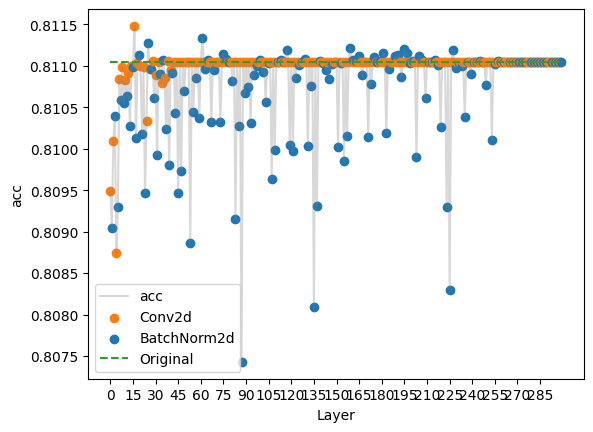

In [7]:
# %matplotlib widget
plot_results(results, layers, "acc")  # loss, acc, miou

* Short Conv module is very robust to injection
* BatchNorm2d is slightly less robust to injection than Conv2d

# Pretrained Model

In [ ]:
import torch
from utils.models.ghostnetv2 import (
    ghostnetv2,
    SegmentationHeadGhostBN,
    GhostNetSS,
    load_fi_weights,
)

# Define the model
backbone = ghostnetv2(
    inject=False,
    # num_classes=0,
    error_model="single",
    inject_p=0.0001,
    inject_epoch=0,
    #     ckpt="ckpt/GN_SSL_280.pt",
)

x = torch.randn(1, 5, 512, 512)
y, intermediates = backbone(x)
print(y.shape)
print([inter.shape for inter in intermediates])

In [2]:
head = SegmentationHeadGhostBN()
model = GhostNetSS(backbone, head)

In [ ]:
model = load_fi_weights(model, "ckpt/bb_heads_clouds.pth").cuda()

# Misc

In [ ]:
# From TIF file to numpy array

import numpy as np
import rasterio

img_path = "data/2021-09-01T10-00-00Z.tif"

# Open the images using rasterio
with rasterio.open(img_path) as img:
    b02 = img.read(2)  # Band 2 = Blue
    b03 = img.read(3)  # Band 3 = Green
    b04 = img.read(4)  # Band 4 = Red
    b08 = img.read(8)  # Band 8 = NIR
    b11 = img.read(11)  # Band 11 = SWIR1

    # Stack the bands
    img_image = np.stack([b02, b03, b04, b08, b11], axis=0).astype(np.float32)
# From TIF file to numpy array

import numpy as np
import rasterio

img_path = "data/2021-09-01T10-00-00Z.tif"

# Open the images using rasterio
with rasterio.open(img_path) as img:
    b02 = img.read(2)  # Band 2 = Blue
    b03 = img.read(3)  # Band 3 = Green
    b04 = img.read(4)  # Band 4 = Red
    b08 = img.read(8)  # Band 8 = NIR
    b11 = img.read(11)  # Band 11 = SWIR1

    # Stack the bands
    img_image = np.stack([b02, b03, b04, b08, b11], axis=0).astype(np.float32)